# Trend Analysis in Cell Differentiation

In this tutorial, we'll provide a guide on how to use the Mellon library in conjunction with Palantir to analyze trends throughout cell differentiation trajectories. This will involve loading a scRNA-seq dataset, selecting cell differentiation branches, calculating gene trends along these branches, and finally, visualizing these trends.

Firstly, let's import the necessary libraries:

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import palantir
import mellon
import scanpy as sc

import warnings
from numba.core.errors import NumbaDeprecationWarning

We'll enable inline plotting for the notebook and suppress the NumbaDeprecationWarning for cleaner output:

In [2]:
%matplotlib inline
warnings.simplefilter("ignore", category=NumbaDeprecationWarning)

## Step 1: Reading and Displaying the Dataset

We start by loading the scRNA-seq dataset. For this demonstration, we will use a publicly available dataset of T-cell depleted bone marrow:

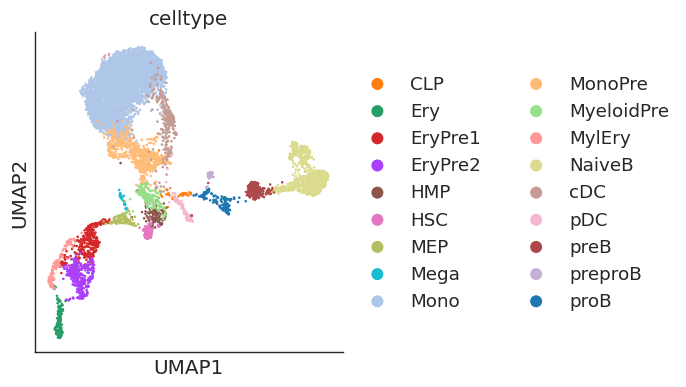

In [3]:
ad_url = "https://fh-pi-setty-m-eco-public.s3.amazonaws.com/mellon-tutorial/preprocessed_t-cell-depleted-bm.h5ad"
ad = sc.read("data/preprocessed_t-cell-depleted-bm.h5ad", backup_url=ad_url)
sc.pl.scatter(ad, basis="umap", color="celltype")

Please note that the annData object `ad` we've loaded has already been processed with Palantir following the
[Palantir tutorial notebook](https://github.com/dpeerlab/Palantir/blob/master/notebooks/Palantir_sample_notebook.ipynbhttps://github.com/dpeerlab/Palantir/blob/master/notebooks/Palantir_sample_notebook.ipynb).
It includes the Palantir pseudotime in `ad.obs["palantir_pseudotime"]` and fate probabilities for
different branches in `ad.obsm["palantir_fate_probabilities"]`. You can check these by:

In [4]:
ad.obsm["palantir_fate_probabilities"].head()

,Mono,pDC,NaiveB,Ery
IM-1393_BoneMarrow_TcellDep_1_multiome#GTGAGCGAGTCTCACC-1,0.787378,0.144244,0.04321,0.025167
IM-1393_BoneMarrow_TcellDep_1_multiome#GAGTCAAAGTCCTTCA-1,0.000000,0.000000,0.00000,0.999998
IM-1393_BoneMarrow_TcellDep_1_multiome#TGTGCGCAGTCGCTAG-1,0.000000,0.000000,0.00000,1.000000
IM-1393_BoneMarrow_TcellDep_1_multiome#ATATGTCCAATGCCTA-1,0.999720,0.000000,0.00000,0.000000
IM-1393_BoneMarrow_TcellDep_1_multiome#CTTAGTTTCGCTAGTG-1,0.000000,0.000000,0.00000,1.000000


## Step 2: Branch selection

To evaluate density along a differentiation branch, we need to select all cells that we consider to represent different states along this branch. For manual selection, we write a pandas DataFrame with boolean values to a `ad.obsm` array and name the columns according to the selected branches:

In [5]:
ad.obsm["custom_branch_mask"] = pd.DataFrame(
    {"NaiveB": ad.obs["NaiveB_lineage"] == "True"}
)

We can inspect this selection using Palantir:

/fh/fast/setty_m/user/dotto/mamba/envs/mellon_v2/lib/python3.10/site-packages/palantir/plot.py:688: UserWarning: Found only 1 fates in the intersection of 4 fate-probability fates in .obsm['palantir_fate_probabilities'] fates) and 1 fate-mask fates in .obsm['custom_branch_mask'].
  warnings.warn(


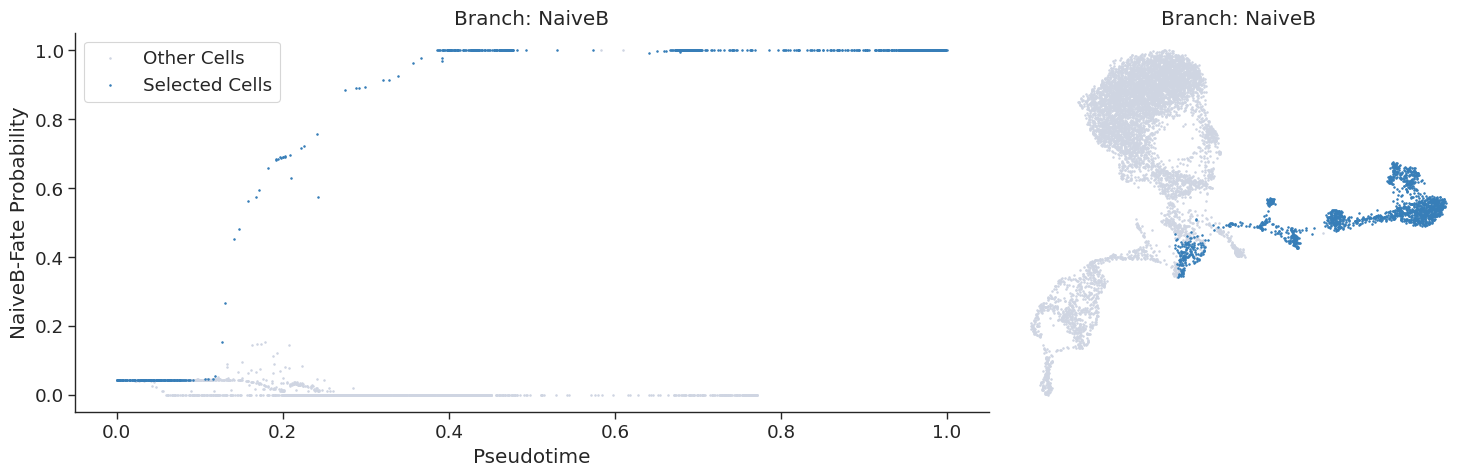

In [6]:
palantir.plot.plot_branch_selection(ad, masks_key="custom_branch_mask", s=1)
plt.show()

Alternatively, to automate such a selection, we can use the Palantir fate probabilities and the `select_branch_cells` tool. Palantir stores these results in `ad.obsm["branch_masks"]` by default:

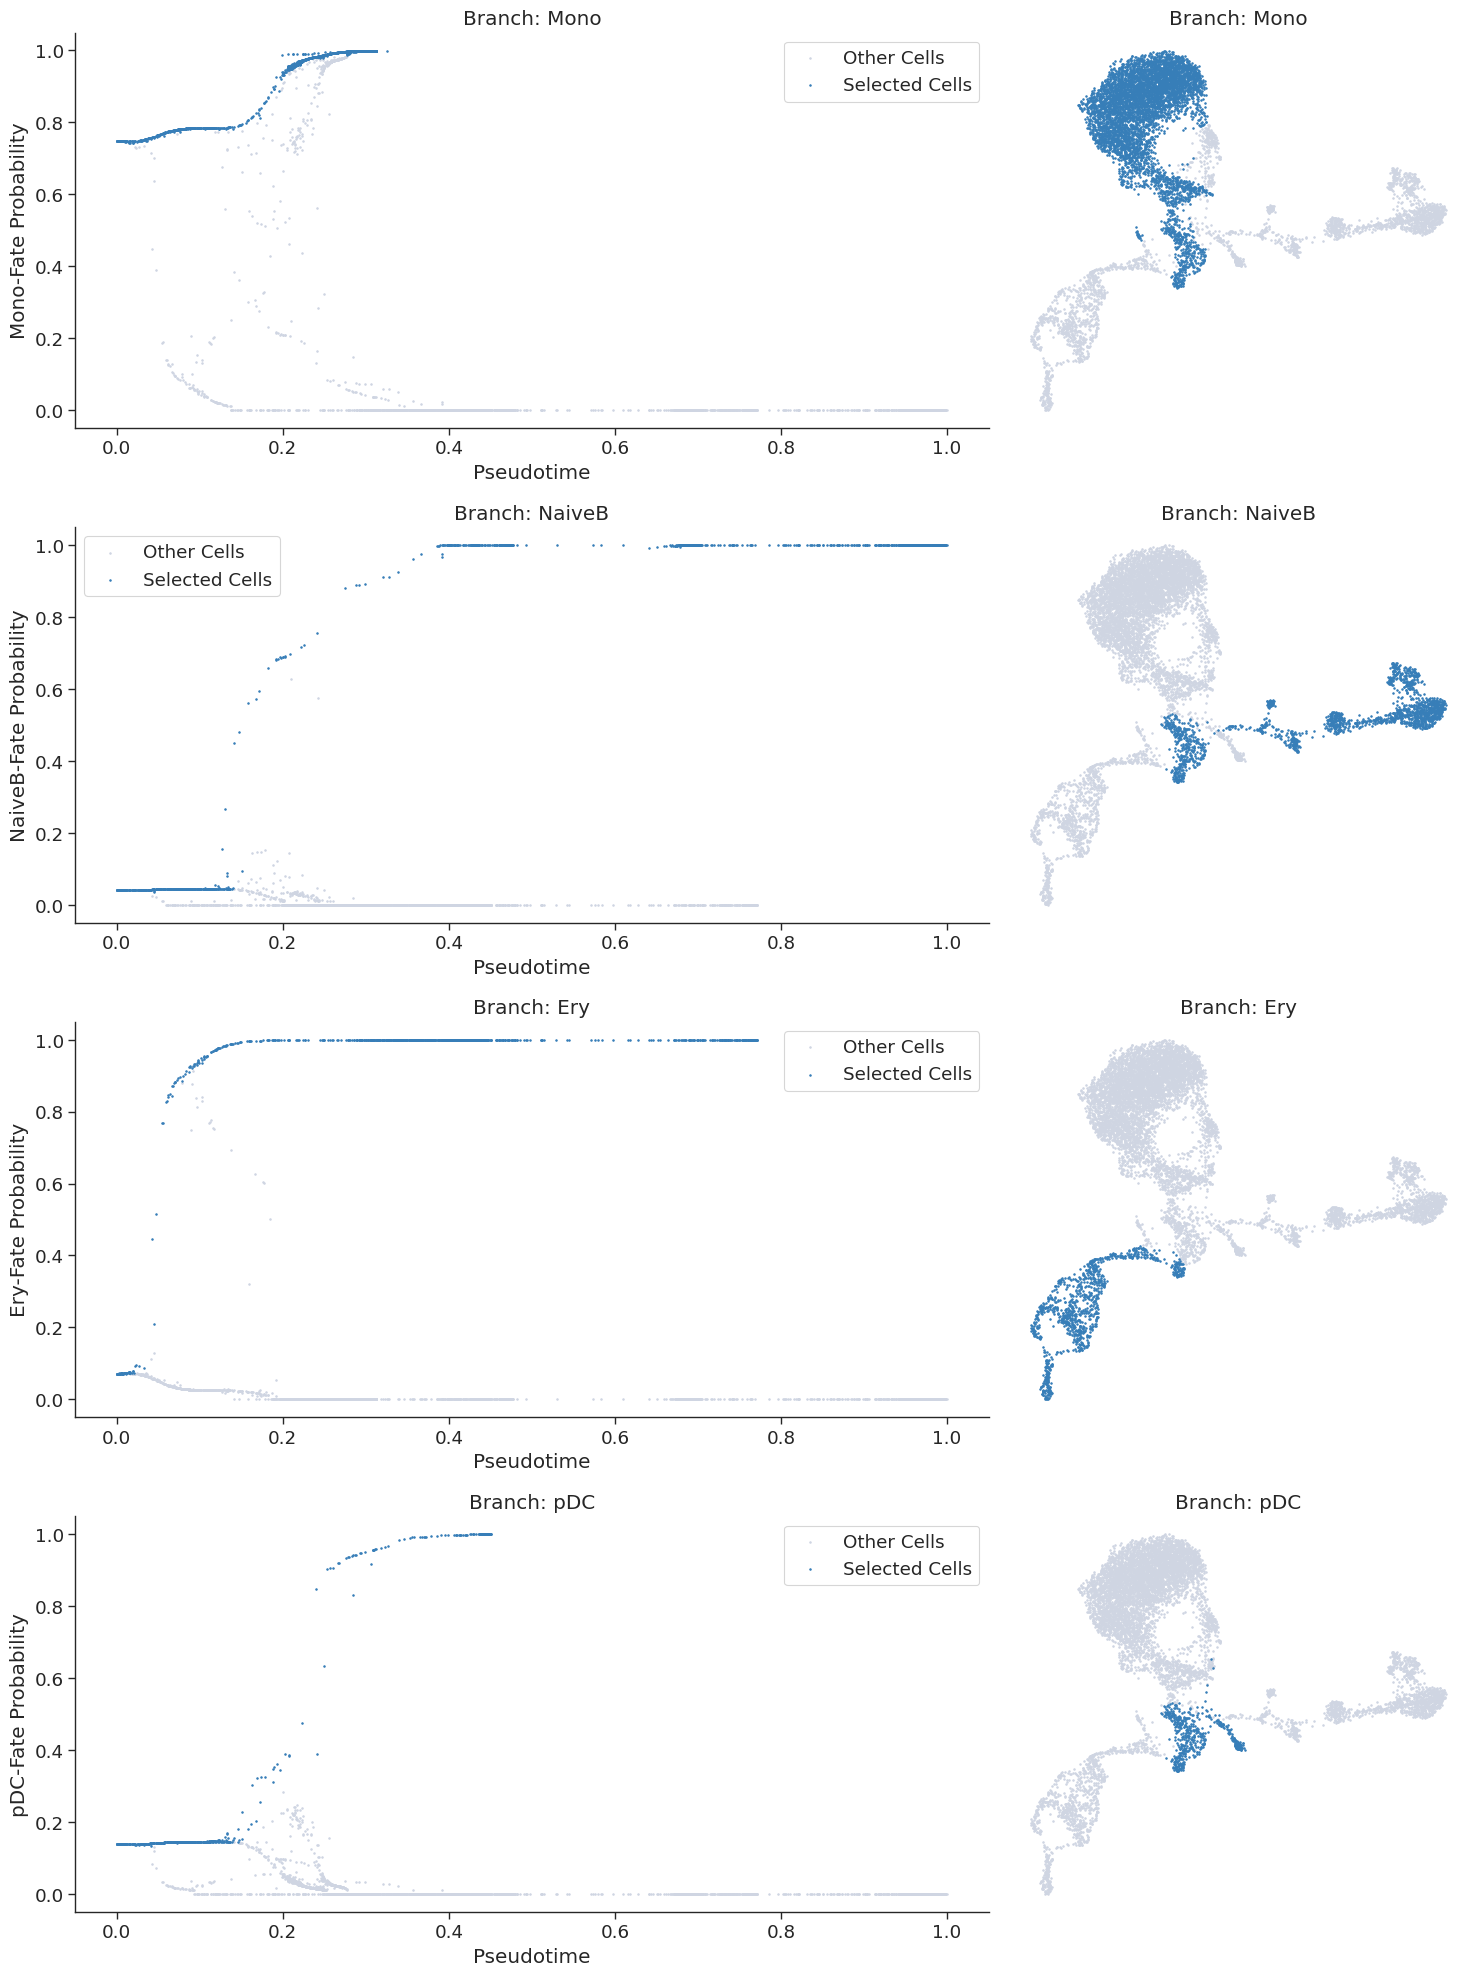

In [7]:
palantir.presults.select_branch_cells(ad)
palantir.plot.plot_branch_selection(ad, s=1)
plt.show()

## Step 3: Calculate gene trends

Next, we'll use Mellon's [FunctionEstimator](https://mellon.readthedocs.io/en/latest/model.html#mellon.model.FunctionEstimator) to compute the trend of gene expressions throughout the differentiation trajectories. This requires the cell selection, log-transformed gene expressions of the selected cells, pseudot

imes of the selected cells, and a grid of pseudotime values at which we want to evaluate the gene trends:

In [8]:
selection = ad.obsm["custom_branch_mask"]["NaiveB"]
pseudotimes = ad[selection, :].obs["palantir_pseudotime"]
expressions = ad[selection, :].X
pseudotim_grid = np.linspace(pseudotimes.min(), pseudotimes.max(), 200)

Gene trends are unique to each gene (`ad.var`) and each differentiation branch. To store these trends within the AnnData structure, we write a DataFrame to an `ad.varm` array. Additionally, to link these trends to the specific pseudotimes at which they've been evaluated, we store the pseudotimes in `ad.uns["<trend key>_pseudotime"]`. This enables the Palantir library to access these results for plotting purposes:

In [9]:
%%time
model = mellon.FunctionEstimator(ls=10, sigma=1)
trends = model.fit_predict(pseudotimes, expressions, pseudotim_grid)
ad.varm["custom_mellon_trends_NaiveB"] = trends.T
ad.uns["custom_mellon_trends_NaiveB_pseudotime"] = pseudotim_grid

[2023-06-23 19:00:58,811] [INFO    ] Using covariance function Matern52(ls=10.0).
CPU times: user 6.48 s, sys: 4.44 s, total: 10.9 s
Wall time: 2.12 s


Palantir also offers a wrapper for the `mellon.FunctionEstimator` to run the trend computation on all branches simultaneously and store them in `ad.varm["gene_trends_<fate>"]`:

In [10]:
%%time
trends = palantir.presults.compute_gene_trends(ad)

Mono
[2023-06-23 19:01:01,436] [INFO    ] Using covariance function Matern52(ls=10.0).
pDC
[2023-06-23 19:01:07,502] [INFO    ] Using covariance function Matern52(ls=10.0).
NaiveB
[2023-06-23 19:01:08,825] [INFO    ] Using covariance function Matern52(ls=10.0).
Ery
[2023-06-23 19:01:10,819] [INFO    ] Using covariance function Matern52(ls=10.0).
CPU times: user 52.6 s, sys: 23.4 s, total: 1min 16s
Wall time: 11.5 s


## Step 4: Plotting Trends

Finally, we can use Palantir's plotting functions to conveniently inspect the results:

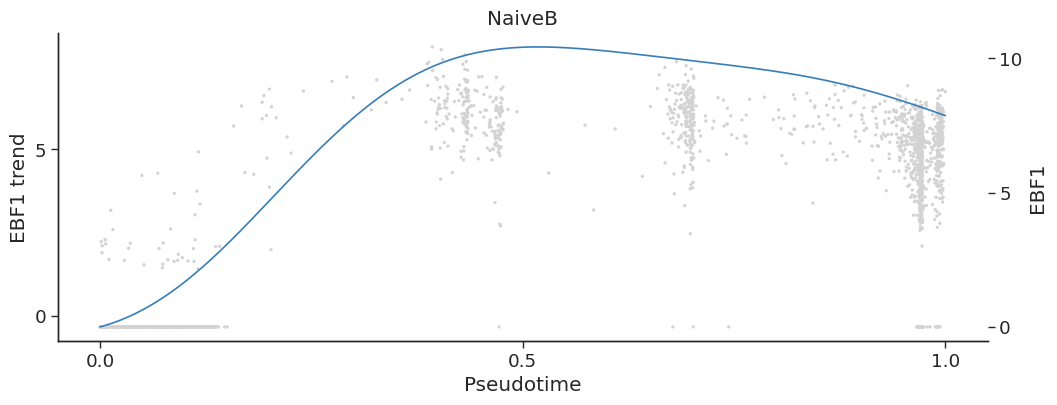

In [11]:
palantir.plot.plot_trend(ad, "NaiveB", "EBF1")
plt.show()

To use our custom cell selection and trend computation the respective keys have to be supplied.
Note that we ommit the `"_NaiveB"` in the `gene_trend_key`.

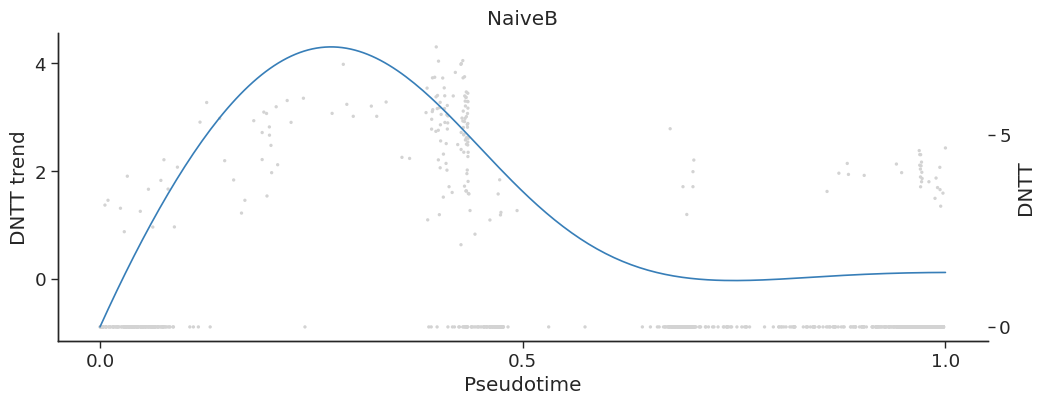

In [12]:
palantir.plot.plot_trend(
    ad,
    "NaiveB",
    "DNTT",
    masks_key="custom_branch_mask",
    gene_trend_key="custom_mellon_trends",
)
plt.show()

We can customize the colorings of the cells based on different genes or other cellular characteristics stored in the `ad.obs` dataframe.

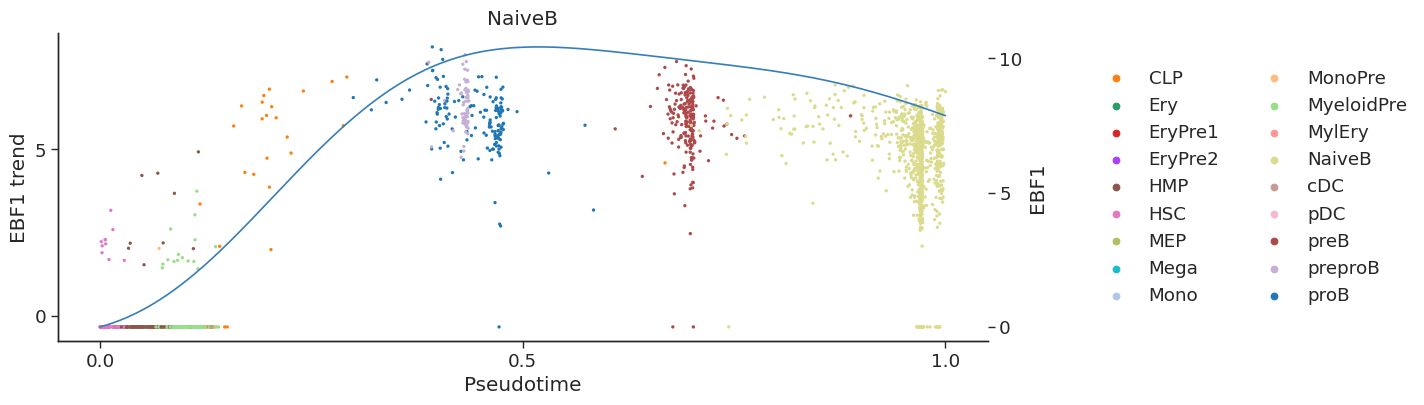

In [13]:
palantir.plot.plot_trend(ad, "NaiveB", "EBF1", color="celltype")
plt.show()

In addition to customizing the cell colors, we can also modify the y-position of the cells in the scatter plot, allowing for visualization based on different genes or other cellular characteristics stored in the `ad.obs` dataframe. For we can plot the cells according to the Mellon log-density:

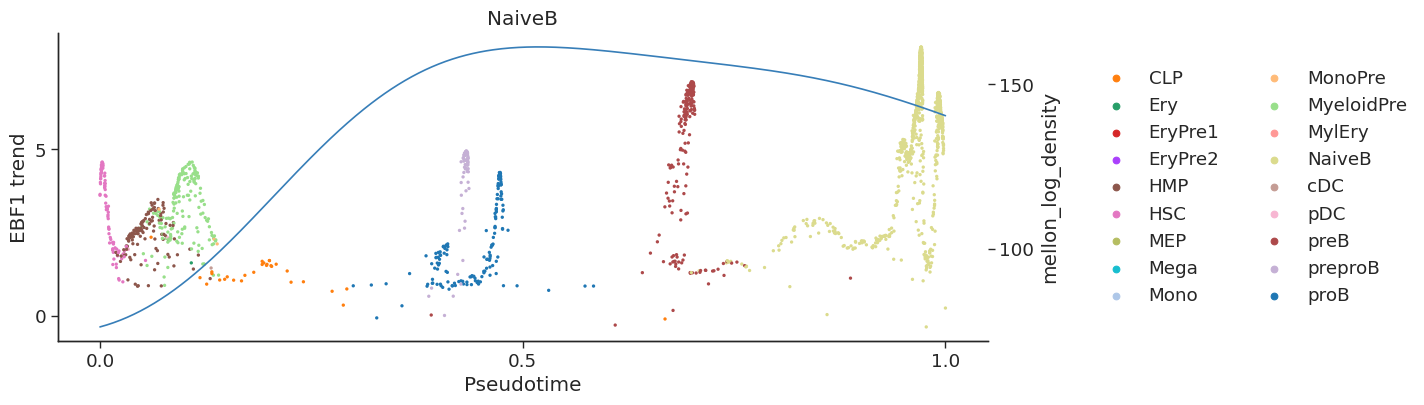

In [14]:
palantir.plot.plot_trend(
    ad, "NaiveB", "EBF1", color="celltype", position="mellon_log_density"
)
plt.show()

Another insightful characteristic is the local variability of genes at different stages of the differentiation trajectory. These variabilities can be computed using Palantir and are stored in `ad.layers["local_variability"]`. To visualize this variability alongside the gene expression trends, we need to specify a layer from which this information will be retrieved for the gene:

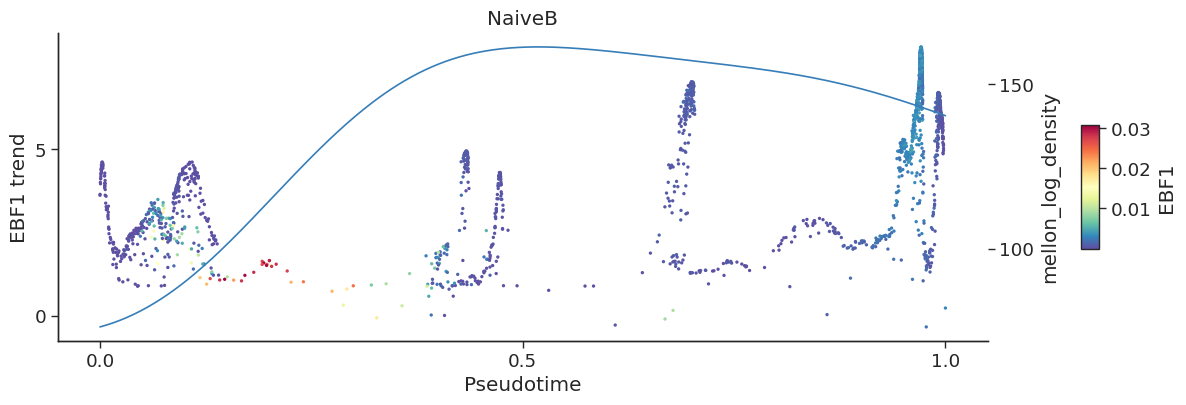

In [15]:
palantir.utils.run_local_variability(ad)
palantir.plot.plot_trend(
    ad,
    "NaiveB",
    "EBF1",
    color="EBF1",
    position="mellon_log_density",
    color_layer="local_variability",
)
plt.show()

In conclusion, this tutorial has demonstrated how to use Mellon and Palantir to perform trend analysis in cell differentiation trajectories. This includes selecting branches, calculating gene trends along these branches, and visualizing the results.